In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mipt-hakaton-summer-2022/test_dataset_test/1017.png
/kaggle/input/mipt-hakaton-summer-2022/test_dataset_test/815.png
/kaggle/input/mipt-hakaton-summer-2022/test_dataset_test/780.png
/kaggle/input/mipt-hakaton-summer-2022/test_dataset_test/1012.png
/kaggle/input/mipt-hakaton-summer-2022/test_dataset_test/771.png
/kaggle/input/mipt-hakaton-summer-2022/test_dataset_test/48.png
/kaggle/input/mipt-hakaton-summer-2022/test_dataset_test/1037.png
/kaggle/input/mipt-hakaton-summer-2022/test_dataset_test/350.png
/kaggle/input/mipt-hakaton-summer-2022/test_dataset_test/655.png
/kaggle/input/mipt-hakaton-summer-2022/test_dataset_test/762.png
/kaggle/input/mipt-hakaton-summer-2022/test_dataset_test/927.png
/kaggle/input/mipt-hakaton-summer-2022/test_dataset_test/231.png
/kaggle/input/mipt-hakaton-summer-2022/test_dataset_test/645.png
/kaggle/input/mipt-hakaton-summer-2022/test_dataset_test/348.png
/kaggle/input/mipt-hakaton-summer-2022/test_dataset_test/621.png
/kaggle/input/mipt-haka

In [2]:
#  Устанавливаю последние стабильные версии torch и torchvision
!pip install torch==1.12.0+cu116 torchvision==0.13.0+cu116 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 GB 762.9 kB/s eta 0:00:000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 15.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0
    Uninstalling torchvision-0.12.0:
      Successfully uninstalled torchvision-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobuf 3.19.4 which is incompatible.
allennlp 2.10.0 requires torch<1.12.0,>=1.10.0, but you have torch 1.12.0+cu116 which is incompatible.
allennlp 2.10.0 requires torchvision<0.13.0,>=0.8.1,

In [3]:
!pip install torchinfo

In [4]:
import random
import pandas as pd 
import numpy as np
import glob
from glob import glob
from tqdm import tqdm
import cv2
import os
from os import listdir
import zipfile

from sklearn.model_selection import train_test_split
import json
from math import sin, cos

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, models, transforms
from torchinfo import summary

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [5]:
# фиксирую случайности
seed = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed)

### Преобразование начального датасета в pandas-датафрейм

In [6]:
json_dir = "/kaggle/input/mipt-hakaton-summer-2022/train_dataset_train/train/json/"

data_df = pd.DataFrame({'id': [], "left_top_x": [], 'left_top_y': [], "right_bottom_x": [],
                        'right_bottom_y': [], 'angle': []})

json_true = []
for _, _, files in os.walk(json_dir):
    for x in files:
        if x.endswith(".json"):
            data = json.load(open(json_dir + x))
            new_row = {'id':x.split(".")[0]+".png", 'left_top_x':data["left_top"][0],
                       'left_top_y':data["left_top"][1], 'right_bottom_x': data["right_bottom"][0],
                       "right_bottom_y": data["right_bottom"][1], 'angle': data["angle"]}
            data_df = data_df.append(new_row, ignore_index=True)

In [7]:
data_df.head(5)

,id,left_top_x,left_top_y,right_bottom_x,right_bottom_y,angle
0,1125.png,10326.0,2016.0,9395.0,3125.0,85.0
1,546.png,1028.0,8522.0,2475.0,8471.0,313.0
2,423.png,3958.0,6397.0,4909.0,5304.0,266.0
3,1133.png,5887.0,10437.0,6430.0,9094.0,247.0
4,225.png,6424.0,3967.0,4981.0,3840.0,140.0


### Напишем класс, в котором данные непосредственно загружаются и приводятся в нужный формат

In [8]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, labels = self.data_df.iloc[idx]['id'], [self.data_df.iloc[idx]['left_top_x']/10496, 
        self.data_df.iloc[idx]['left_top_y']/10496, self.data_df.iloc[idx]['right_bottom_x']/10496, 
        self.data_df.iloc[idx]['right_bottom_y']/10496, self.data_df.iloc[idx]['angle']/360]

        # читаем картинку. read the image
        image = cv2.imread(f"/kaggle/input/mipt-hakaton-summer-2022/train_dataset_train/train/img/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(labels).float()
    
    def __len__(self):
        return len(self.data_df)

### Зададим аугментации, которые будут использоваться при обучении модели

In [9]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(608),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.RandomResizedCrop(608),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

### Посмотрим на количество данных и разделим их на тренировочную и валидационную части

In [10]:
print("Обучающей выборки " ,len(listdir("/kaggle/input/mipt-hakaton-summer-2022/train_dataset_train/train/img/")))
print("Тестовой выборки " ,len(listdir("/kaggle/input/mipt-hakaton-summer-2022/test_dataset_test/")))

Обучающей выборки  800
Тестовой выборки  400


In [11]:
train_df, valid_df = train_test_split(data_df, random_state=seed, test_size=0.1)

In [12]:
train_df.shape, valid_df.shape

((720, 6), (80, 6))

In [13]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [14]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True,
                                           pin_memory=True, num_workers=2)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=4, shuffle=False,
                                           pin_memory=True, num_workers=2)

In [15]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [16]:
images.shape

torch.Size([4, 3, 608, 608])

In [17]:
labels.shape

torch.Size([4, 5])

## Вспомогательная функция

In [18]:
def compute_metric(data_true, data_pred, outImageW = 10496, outImageH = 10496):

    x_center_true = np.array((data_true[0] + data_true[2])/2).astype(int)
    y_center_true = np.array((data_true[1] + data_true[3])/2).astype(int)

    x_metr = x_center_true - np.array((data_pred[0] + data_pred[2])/2).astype(int)
    y_metr = y_center_true - np.array((data_pred[1] + data_pred[3])/2).astype(int)

    metr =  1 - 0.7 * (abs(x_metr)/outImageH + abs(y_metr)/outImageW)/2 + 0.3 *abs(data_pred[4] - data_true[4])/359
    return metr

### Функция визуализации графиков обучения

In [19]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure(figsize=(16, 9))
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='red', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

### Процесс обучения модели написан вручную

In [20]:
def train(res_model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = []

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.cuda()
            labels = labels.cuda()

            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append((loss.data.cpu().detach().numpy() / y_pred.size(0)) * 100)
            
            y_pred[:, :4] = y_pred[:, :4] * 10496
            y_pred[:, -1] = y_pred[:, -1] * 360

            labels[:, :4] = labels[:, :4] * 10496
            labels[:, -1] = labels[:, -1] * 360

            for label, pr in zip(labels, y_pred):
                    train_pred.append(compute_metric(label.cpu().detach().numpy(), pr.cpu().detach().numpy()))

            optimizer.step()

        train_acc_log.append(train_pred)

        val_loss = 0.
        val_size = 0
        
        val_pred = []
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(imgs)
                loss = criterion(pred, labels)

                pred[:, :4] = pred[:, :4] * 10496
                pred[:, -1] = pred[:, -1] * 360

                labels[:, :4] = labels[:, :4] * 10496
                labels[:, -1] = labels[:, -1] * 360
                
                val_loss += loss.item()
                val_size += pred.size(0)

                for label, pr in zip(labels, pred):
                    val_pred.append(compute_metric(label.cpu().detach().numpy(), pr.cpu().detach().numpy()))

        val_loss_log.append((val_loss / val_size)*100)
        val_acc_log.append(val_pred)
        
        scheduler.step()

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')
        


        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train metric:', (np.mean(train_pred)))
        print('Val metric:', (np.mean(val_pred)))
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

### В качестве модели использую efficientnet_v2_l, предобученный на датасете imagenet с выходным слоем размером 5. Функцией потерь будет MSELoss, используемый в задачах регрессии

In [21]:
model = models.efficientnet_v2_l(weights="IMAGENET1K_V1")
model.classifier[1] = nn.Linear(1280, 5)

criterion = torch.nn.MSELoss()

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth


  0%|          | 0.00/455M [00:00<?, ?B/s]

In [22]:
model_info = summary(model)
print('Обучаемых параметров у получившейся модели:', model_info.trainable_params)

Обучаемых параметров у получившейся модели: 117240677


In [23]:
summary(model, (4, 3, 608, 608))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [4, 5]                    --
├─Sequential: 1-1                                       [4, 1280, 19, 19]         --
│    └─Conv2dNormActivation: 2-1                        [4, 32, 304, 304]         --
│    │    └─Conv2d: 3-1                                 [4, 32, 304, 304]         864
│    │    └─BatchNorm2d: 3-2                            [4, 32, 304, 304]         64
│    │    └─SiLU: 3-3                                   [4, 32, 304, 304]         --
│    └─Sequential: 2-2                                  [4, 32, 304, 304]         --
│    │    └─FusedMBConv: 3-4                            [4, 32, 304, 304]         9,280
│    │    └─FusedMBConv: 3-5                            [4, 32, 304, 304]         9,280
│    │    └─FusedMBConv: 3-6                            [4, 32, 304, 304]         9,280
│    │    └─FusedMBConv: 3-7                      

In [24]:
torch.cuda.empty_cache()

In [25]:
model = model.cuda()

In [26]:
optimizer = torch.optim.RAdam(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### Запущу обучение и понаблюдаю за изменением лоссов

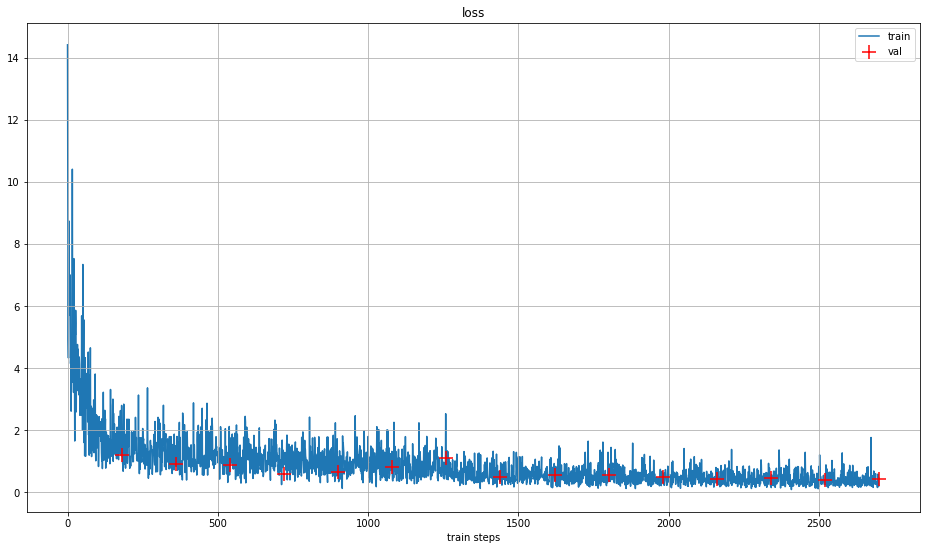

100%|██████████| 15/15 [36:57<00:00, 147.84s/it]

Train loss: 0.40053766667066765
Val loss: 0.42155698349233717
Train metric: 0.985908164454557
Val metric: 0.9954599996106814


In [27]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, criterion, optimizer, train_loader, 
                                                                 valid_loader, NUM_EPOCH=15)

### Посчитаю метрику на датасете для валидации

In [28]:
total_metric = []

for imgs, labels in valid_loader:
    imgs = imgs.cuda()
    labels = labels.cpu().detach().numpy()            
    pred = model(imgs)
    pred = pred.cpu().detach().numpy()    

    pred[:, :4] = pred[:, :4] * 10496
    pred[:, -1] = pred[:, -1] * 360

    labels[:, :4] = labels[:, :4] * 10496
    labels[:, -1] = labels[:, -1] * 360
    
    for label, pr in zip(labels, pred):
        total_metric.append(compute_metric(label, pr))
    
total_metric = np.mean(total_metric)
print('Total metric:', total_metric)

Total metric: 0.9992817458439734


### Создаю предсказания на тестовом наборе данных

In [29]:
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [30]:
class TestImageDataset(Dataset):
    def __init__(self, files, transform=None):

        self.files = files
        self.transform = transform

    def __getitem__(self, idx):

        image_name = self.files[idx]

        # читаем картинку. read the image
        image = cv2.imread(f"/kaggle/input/mipt-hakaton-summer-2022/test_dataset_test/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image
    
    def __len__(self):
        return len(self.files)

In [31]:
test_images_dir = '/kaggle/input/mipt-hakaton-summer-2022/test_dataset_test/'

for _, _, test_files in os.walk(test_images_dir):
    break

test_dataset = TestImageDataset(test_files, valid_transform)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, 
                                          pin_memory=True, num_workers=2)

### Собираю предсказания в список

In [32]:
indexes = [x.split('.')[0] for x in test_files]
preds = []

for imgs in test_loader:
    imgs = imgs.cuda()            
    pred = model(imgs)
    pred = pred.cpu().detach().numpy()
    pred[:, :4] = np.clip(pred[:, :4] * 10496, 0, 10496)
    pred[:, -1] = np.clip(pred[:, -1] * 360, 0, 360)
    preds.extend(list(pred))

### Записываю полученные предсказания в нужный для сабмита формат. После чего сжимаю все .json-файлы в архив и загружаю его на платформу

In [33]:
sub_dir = "/kaggle/working/"
if not os.path.exists(sub_dir):
    os.makedirs(sub_dir)

json_true = []

for indx, pred in zip(indexes, preds):

    pred = [int(x) for x in pred]

    left_top = [pred[0], pred[1]]
    right_top = [pred[2], pred[1]]
    left_bottom = [pred[0], pred[3]]
    right_bottom = [pred[2], pred[3]]
        
    res = {
        'left_top': left_top,
        'right_top': right_top,
        'left_bottom': left_bottom,
        'right_bottom': right_bottom,
        'angle': pred[4]
    }

    with open(sub_dir+indx+'.json', 'w') as f:
        json.dump(res, f)

In [35]:
fantasy_zip = zipfile.ZipFile('/kaggle/working/efficientnet_v2_l_4b_608s_15e_sc7.zip', 'w')

for folder, subfolders, files in os.walk('/kaggle/working/'):
    
    for file in files:
        if file.endswith('.json'):
            fantasy_zip.write(os.path.join(folder, file),
                              os.path.relpath(os.path.join(folder,file),'/kaggle/working/'),
                              compress_type = zipfile.ZIP_DEFLATED)
fantasy_zip.close()